In [1]:
import torch

import matplotlib.pyplot as plt
%matplotlib inline

import pytorch_lightning as pl

import bliss
import bliss.models.galaxy_net
import bliss.datasets.galsim_galaxies

In [2]:
import numpy as np

In [3]:
pl.seed_everything(743384)

743384

# Create dataset

First we create the dataset containing SDSS galaxies. These galaxies have realistic sizes and fluxes from a catalog, but the morphology is bulge+disk+agn (basically a parametric Sersic mixture) so they are not as realistic as they could be. 

In [4]:
# the catalog we will be using has a sample of 'easiest' (not too small or too faint) galaxies in the catalog.
catalog_file = '../../data/gold_dc2_catalog.fits'

In [5]:
# we prepare a configuration object that is used to create the dataset & model.
from hydra.experimental import initialize, compose
def get_cfg(overrides):
    overrides = [f"{key}={value}" for key, value in overrides.items()]
    with initialize(config_path="../../config"):
        cfg = compose("config", overrides=overrides)
    return cfg

overrides = {
             # dataset information
             'dataset':'sdss_galaxies', 'dataset.cosmoDC2_file': catalog_file,
    
             # model info. 
             'model':'galaxy_net',
    
             # pytorch lightning trainer. 
             'training': 'default'
}
cfg = get_cfg(overrides)


# more over-rides
cfg.dataset.update({'batch_size': 10, 'n_batches': 1})

dataset = bliss.datasets.galsim_galaxies.SDSSGalaxies(cfg)

In [6]:
cfg

{'mode': 'train', 'general': {'overwrite': False}, 'gpus': [0], 'paths': {'root': '${env:BLISS_HOME}', 'data': '${paths.root}/data', 'models': '${paths.root}/models', 'output': '${paths.root}/temp/default', 'sdss': '${paths.root}/data/sdss'}, 'optimizer': {'name': 'torch.optim.Adam', 'params': {'lr': 0.0001, 'weight_decay': 1e-06}}, 'model': {'name': 'OneCenteredGalaxy', 'warm_up': 0, 'params': {'slen': 51, 'latent_dim': 8, 'n_bands': 1, 'hidden': 256}}, 'training': {'deterministic': False, 'plotting': True, 'n_epochs': 121, 'trainer': {'profiler': None, 'logger': True, 'checkpoint_callback': False, 'reload_dataloaders_every_epoch': False, 'max_epochs': '${training.n_epochs}', 'min_epochs': '${training.n_epochs}', 'gpus': '${gpus}', 'limit_train_batches': 1.0, 'limit_val_batches': 1.0, 'check_val_every_n_epoch': 10}}, 'dataset': {'name': 'SDSSGalaxies', 'cosmoDC2_file': '../../data/gold_dc2_catalog.fits', 'batch_size': 10, 'n_batches': 1, 'num_workers': 0, 'params': {'background': 865,

In [7]:
%matplotlib inline

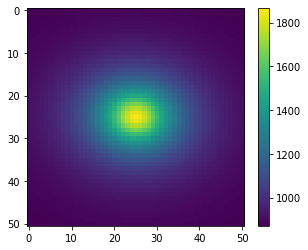

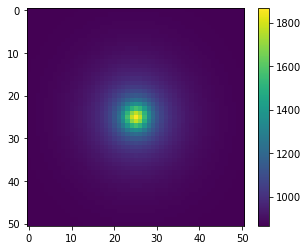

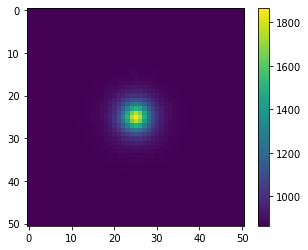

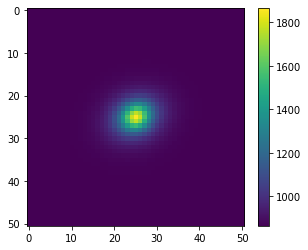

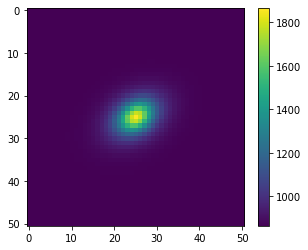

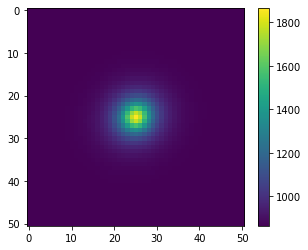

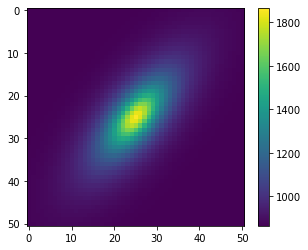

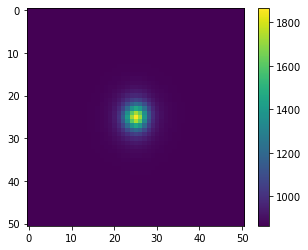

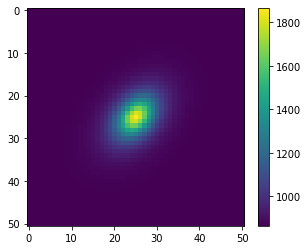

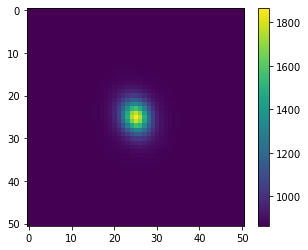

In [8]:
for i in range(10): 
    fig, ax = plt.subplots(1,1, figsize=(5, 4))
    ex = dataset[i]
    im = ax.imshow(ex['images'][0])
    fig.colorbar(im, ax=ax)

In [9]:
for i in range(5): 
    print((dataset[0]['images']**2).mean())

1035625.2
1035625.2
1035625.2
1035625.2
1035625.2


# Create VAE and Train

The configuration object we created above already contains the model information for our galaxy VAE. 

In [10]:
print(cfg.model)

{'name': 'OneCenteredGalaxy', 'warm_up': 0, 'params': {'slen': 51, 'latent_dim': 8, 'n_bands': 1, 'hidden': 256}}


We can create the VAE directly from this configuration. 

In [11]:
VAE = bliss.models.galaxy_net.OneCenteredGalaxy(cfg)

And we also need a trainer to train. 

In [ ]:
# create trainer
n_epochs = 2000
trainer = pl.Trainer(profiler=None, logger=False, checkpoint_callback=False, 
                     max_epochs=n_epochs, min_epochs=n_epochs, 
                     gpus=[2], check_val_every_n_epoch=100,)


# train! 
trainer.fit(VAE, datamodule=dataset)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


In [ ]:
torch.save(VAE.state_dict(), './galaxy_vae')

# Compare results

Now that our model is trained we can compare some results. 

In [ ]:
VAE.eval()

# example reconstruction
# some example centered individual galaxies from the dataset.

#always different.
for b in dataset.train_dataloader():
    batch = b
    break

recon_mean, recon_var, _ = VAE(batch['images'],batch['background'])

for i in range(10): 
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15, 3))

    
    obs = batch['images'][i][0]
    recon = recon_mean[i][0].detach()
    var = recon_var[i][0].detach()
    
    # plot
    im1 = ax1.imshow(obs)
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(recon)
    fig.colorbar(im2, ax=ax2)
    
    im3 = ax3.imshow(var * 0.)
    fig.colorbar(im3, ax=ax3)
    
    
    diff = (obs - recon) # / torch.sqrt(var) 
    vmax = diff.abs().max()
    im4 = ax4.imshow(diff, vmax = vmax, vmin = -vmax, cmap = plt.get_cmap('bwr'))
    fig.colorbar(im4, ax = ax4)
    
    fig.tight_layout()

In [ ]:
z_mean, z_var = VAE.enc.forward(batch['images'] - batch['background'])

In [ ]:
plt.hist(z_mean.flatten().detach().numpy());